# <center>Physics-informed neural network</center>

### Problema directo

Se simulará la siguiente EDP parabólica:

\begin{align*}
\frac{\partial u}{\partial t}(x,t) - \frac{\partial^2 u}{\partial x^2}(x,t) & = x + 2\cos(x), & t\in[0, 1], & \quad x\in[0, 2\pi]\\
u(x, 0) & = 2\cos(x), & & \quad  x\in[0, 2\pi]\\
u(x, t) & = 2\cos(x) + tx, &  t\in[0, 1], & \quad x\in\partial[0, 2\pi]\\
\end{align*}

donde se forzó la solución analítica $u(x,t) = 2\cos(x) + tx$.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

#### Red neuronal

In [2]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 1)

        # Inicialización de Xavier para tanh:
        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
        self.apply(init_weights)
    
    def forward(self, x, t):
        input = torch.stack([x, t], axis=1)
        
        for layer in self.inner_layers:
            input = nn.Tanh()(layer(input))
        input = self.last_layer(input)
        
        return input.squeeze(1)

In [3]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### PDE

In [4]:
cos, pi = torch.cos, torch.pi
x_domain, t_domain = [0, 2*pi], [0, 1]

def pde(x, t, net):
    u = net(x, t)
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    return u_t - u_xx - (x + 2*cos(x))

def boundary_condition(x, t):
    return 2*cos(x) + t*x

def initial_condition(x):
    return 2 * cos(x)

def analytical_solution(x, t):
    return 2*cos(x) + t*x

#### Entrenamiento

In [5]:
net = NeuralNetwork(n_layers=2, wide=10)
optimizer = torch.optim.LBFGS(net.parameters(), line_search_fn='strong_wolfe')

In [6]:
samples_initial, samples_boundary, samples_collocation = 500, 500, 500
epochs = 50

# Creación de data (fija):
x_collocation = torch.empty(samples_collocation).uniform_(*x_domain).requires_grad_()
t_collocation = torch.empty(samples_collocation).uniform_(*t_domain).requires_grad_()
target_collocation = torch.zeros(samples_collocation)

x_boundary = torch.tensor(random.choices(x_domain, k=samples_boundary))
t_boundary = torch.empty(samples_boundary).uniform_(*t_domain)
target_boundary = boundary_condition(x_boundary, t_boundary)

x_initial = torch.empty(samples_initial).uniform_(*x_domain)
t_initial = torch.zeros(samples_initial)
target_initial = initial_condition(x_initial)

# Entrenamiento:
for epoch in range(1, epochs + 1):
    
    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        # Colocación:
        pde_collocation = pde(x_collocation, t_collocation, net)
        loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
        
        # Condición de borde:
        u_boundary = net(x_boundary, t_boundary)
        loss_boundary = nn.MSELoss()(u_boundary, target_boundary)
        
        # Condición inicial:
        u_initial = net(x_initial, t_initial)
        loss_initial = nn.MSELoss()(u_initial, target_initial)
        
        # Optimización:
        loss = loss_initial + loss_boundary + loss_collocation
        if loss.requires_grad:
            loss.backward()
        
        return loss
    
    optimizer.step(closure)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | loss: {closure():.4f}')

Epoch 10 | loss: 0.0064
Epoch 20 | loss: 0.0006
Epoch 30 | loss: 0.0003
Epoch 40 | loss: 0.0001
Epoch 50 | loss: 0.0001


#### Simulación y comparación con la solución real

Error uniforme: 0.0079
Error cuadrático medio: 0.0000


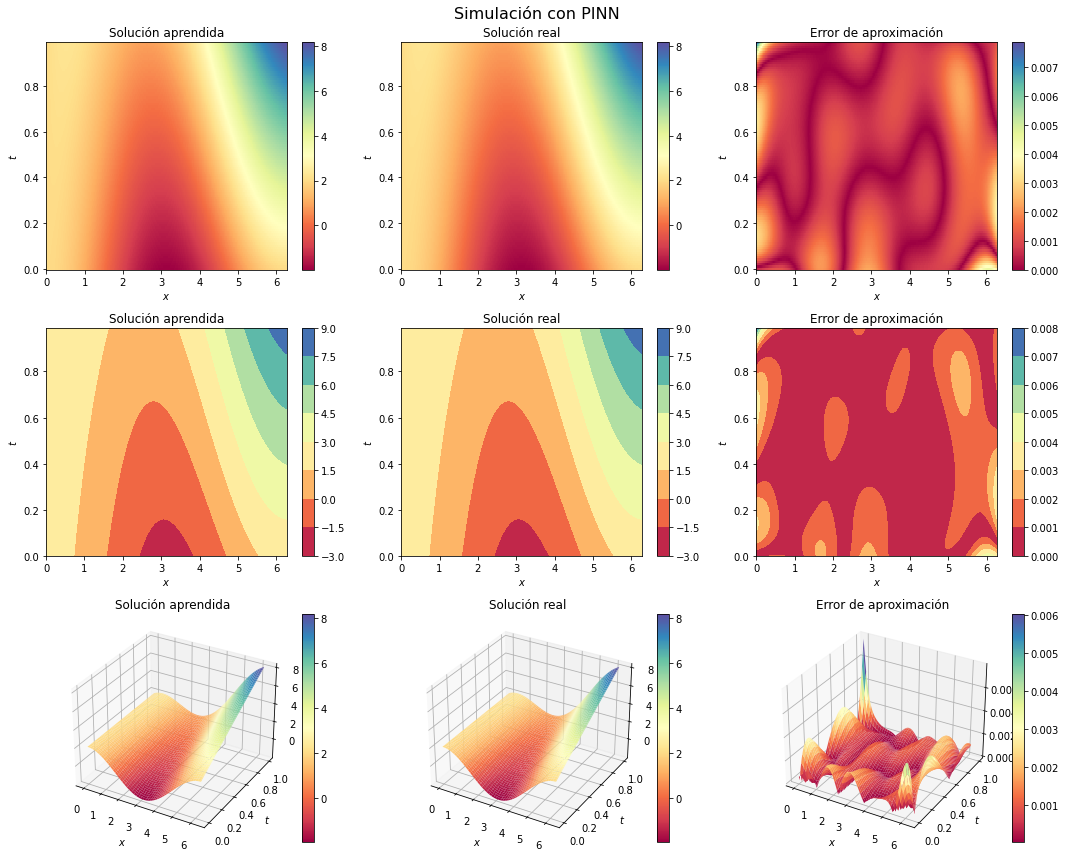

In [7]:
# Puntos del dominio:
x = torch.arange(*x_domain, 1e-2)
t = torch.arange(*t_domain, 1e-2)
grid_x, grid_t = torch.meshgrid(x, t, indexing='ij')
input = grid_x.flatten(), grid_t.flatten()

net.eval()

# Campos a graficar:
u_pred = net(*input).detach()
u_real = analytical_solution(*input)
error = torch.abs(u_real - u_pred)

print(f'Error uniforme: {torch.max(error).item():.4f}')
print(f'Error cuadrático medio: {torch.mean(error**2).item():.4f}')

# Gráficos:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Simulación con PINN', fontsize=16)
plotters = 'pcolormesh', 'contourf', 'plot_surface'

values = {'Solución aprendida': u_pred,
          'Solución real': u_real,
          'Error de aproximación': error}

for i, plotter in enumerate(plotters):
    for j, (key, value) in enumerate(values.items()):
        projection = '3d' if plotter == 'plot_surface' else None
        ax = fig.add_subplot(3, 3, 3*i+j+1, projection=projection)
        simulation = getattr(ax, plotter)(grid_x, grid_t, value.reshape_as(grid_x), cmap='Spectral')
        plt.colorbar(simulation)
        ax.set_title(key)
        ax.set_xlabel('$x$'); ax.set_ylabel('$t$')
plt.tight_layout()
plt.show()